# Classification Analysis for Cheese Data
#### Author: Jenna Le Noble

## Introduction

The purpose of this analysis project is to classify cheese as either high or low in fat. We wish to answer the following question: **given a cheese with various qualities and measurements, how accurately can a machine learning model predict whether the cheese is classified as higher in fat or lower in fat?**

We will build a classification model to answer this question, using lower fat as the positive label. This information can be useful for cheese brands that wish to produce low fat cheese. They can use this classification model to determine which cheese characteristics are likely to result in a low-fat product, in order to cater to people on low-fat diets.

## Exploratory Data Analysis

First, we import all necessary libraries and functions.

In [1]:
import pandas as pd
import numpy as np
import altair as alt
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale)
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC, SVR
import scipy
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import pylab as pl

Next, we can read in our data and preview the raw dataset.

In [2]:
cheese_data = pd.read_csv("data/cheese_data.csv")
cheese_data.head()

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat
2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat
3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat
4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat


**Table 1: Raw Cheese Data**

We will drop some columns for the following reasons:

* `CheeseId`: This variable is an ID and will not contribute to our prediction.
* `FlavourEn`: This is a complex variable that requires the use of `CountVectorizer()`. It is not required to be a factor in our model.
* `CharacteristicsEn`: This is a complex variable that requires the use of `CountVectorizer()`. It is not required to be a factor in our model.
* `RindTypeEn`: This variable will not be used for convenience.
* `CheeseName`: This is a complex variable that requires the use of `CountVectorizer()`. It is not required to be a factor in our model.

In [3]:
cheese_data = cheese_data.drop(columns=['CheeseId', 
                                        'ManufacturerProvCode',
                                        'FlavourEn', 
                                        'CharacteristicsEn', 
                                        'RindTypeEn',
                                        'CheeseName'])
cheese_data.head()

,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,FatLevel
0,Farmstead,47.0,0,Firm Cheese,Ewe,Raw Milk,lower fat
1,Farmstead,47.9,0,Semi-soft Cheese,Cow,Raw Milk,lower fat
2,Industrial,54.0,0,Firm Cheese,Cow,Pasteurized,lower fat
3,Farmstead,47.0,0,Veined Cheeses,Cow,Raw Milk,lower fat
4,Farmstead,49.4,1,Semi-soft Cheese,Cow,Raw Milk,lower fat


**Table 2: Cheese Data with Analysis Columns**

Therefore, we are left with the following columns:

* `ManufacturingTypeEn`: Manufacturing type (Industrial, Artisan or Farmstead)
* `MoisturePercent`: Percentage of moisture in the cheese (%)
* `Organic`: Whether the cheese is organic (0 for inorganic, 1 for organic)
* `CategoryTypeEn`: Cheese category (Soft Cheese, Firm Cheese, Semi-soft Cheese, etc.)
* `MilkTypeEn`: Milk type (Cow, Goat, Ewe, etc.)
* `MilkTreatmentTypeEn`: Milk treatment type (Pasteurized, Raw Milk, Thermised)
* `FatLevel`: Cheese fat level (Lower Fat or Higher Fat)

We can now split our data into train and test sets. We will use a test size of 20% and set `random_state=100` to ensure that our results can be reproduced.

In [4]:
train_df, test_df = train_test_split(cheese_data, test_size=0.2, random_state=100)
train_df.head()

,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,FatLevel
1036,Farmstead,50.0,0,Fresh Cheese,Goat,Pasteurized,lower fat
321,Industrial,42.0,0,Firm Cheese,Cow,Pasteurized,lower fat
244,Industrial,48.0,0,Soft Cheese,Cow,Pasteurized,higher fat
979,Farmstead,47.0,0,Semi-soft Cheese,Ewe,Pasteurized,lower fat
933,Artisan,42.0,0,Semi-soft Cheese,Goat,Pasteurized,lower fat


**Table 3: Train Data**

Now we can explore our data a bit further using `.describe()` and `.info()`.

In [5]:
cheese_data.describe(include='all')

,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,FatLevel
count,1042,1028.000000,1042.000000,1019,1041,977,1042
unique,3,NaN,NaN,6,8,3,2
top,Industrial,NaN,NaN,Firm Cheese,Cow,Pasteurized,lower fat
freq,455,NaN,NaN,349,743,800,684
mean,NaN,47.069747,0.095010,NaN,NaN,NaN,NaN
std,NaN,9.592647,0.293369,NaN,NaN,NaN,NaN
min,NaN,12.000000,0.000000,NaN,NaN,NaN,NaN
25%,NaN,40.000000,0.000000,NaN,NaN,NaN,NaN
50%,NaN,46.000000,0.000000,NaN,NaN,NaN,NaN
75%,NaN,52.000000,0.000000,NaN,NaN,NaN,NaN


**Table 4: Train Data Column Information**

Table 4 demonstrates the summary statistics for our feature and target columns. For example, we can see the number of different categories for each column. `FatLevel` (our target variable) has two categories, while `CategoryTypeEn` has 6 unique categories. Additionally, we can see the mean for our numeric columns such as `MoisturePercent` with its mean of 47.07 %.

In [6]:
cheese_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ManufacturingTypeEn  1042 non-null   object 
 1   MoisturePercent      1028 non-null   float64
 2   Organic              1042 non-null   int64  
 3   CategoryTypeEn       1019 non-null   object 
 4   MilkTypeEn           1041 non-null   object 
 5   MilkTreatmentTypeEn  977 non-null    object 
 6   FatLevel             1042 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 57.1+ KB


**Table 5: Train Data Column Types**

Table 5 tells us that `MoisturePercent` column has dtype `float` so it is numeric. `Organic` column has dtype `int` but only contains two classes so it is binary. The rest of the columns have dtype `object` i.e. `str` and they are categorical columns. Additionally, we can see that `MoisturePercent`, `CategoryTypeEn`, `MilkTypeEn` and `FMilkTreatmentTypeEn` columns contain Null values. To solve this, we will use `SimpleImputer` when we build our model.

We can now explore the distribution of each of our feature variables.

In [7]:
base_chart = alt.Chart(train_df, height=250, width=250).mark_bar().encode(
    y = alt.Y('count():Q', title='Count')
)

chart1 = base_chart.encode(x = alt.X('ManufacturingTypeEn:N')).properties(title="Figure 1: Manufacturing Type Distribution") 
chart2 = base_chart.encode(x = alt.X('MoisturePercent:N', bin=alt.Bin(maxbins=20))).properties(title="Figure 2: Moisture Percent Distribution")
chart3 = base_chart.encode(x = alt.X('Organic:N')).properties(title="Figure 3: Organic Type Distribution")
chart4 = base_chart.encode(x = alt.X('CategoryTypeEn:N')).properties(title="Figure 4: Category Type Distribution")
chart5 = base_chart.encode(x = alt.X('MilkTypeEn:N')).properties(title="Figure 5: Milk Type Distribution")
chart6 = base_chart.encode(x = alt.X('MilkTreatmentTypeEn:N')).properties(title="Figure 6: Milk Treatment Distribution")

(chart1 | chart2 | chart3) & (chart4 | chart5 | chart6)

alt.VConcatChart(...)

(Huppenkothen, 2022)

Figures 1-6 show the distribution of each of our factor columns and their different categories. We can see that some types are more common than others, e.g. Organic value 0 (non-organic) is much more popular than value 1 (organic). We can also explore the distribution of our target variable, `FatLevel`.

In [8]:
target_chart = alt.Chart(train_df, height=300, width=300).mark_bar().encode(
    x = alt.X('FatLevel:N'),
    y = alt.Y('count():Q', title='Count')
).properties(title="Figure 7: Fat Level Distribution")
target_chart

alt.Chart(...)

Figure 7 shows that there is almost double the amount of datapoints that are classified as lower fat than higher fat in our training set. Thus, we can see that the target classes are not balanced. Therefore, we can use `class_weight = 'balanced'` in our estimator.

## Methods & Results

First, lets split our train and test data into features and target data.

In [9]:
X_train, y_train = train_df.drop(columns='FatLevel'), train_df['FatLevel']
X_test, y_test = test_df.drop(columns='FatLevel'), test_df['FatLevel']
X_train.head()

,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn
1036,Farmstead,50.0,0,Fresh Cheese,Goat,Pasteurized
321,Industrial,42.0,0,Firm Cheese,Cow,Pasteurized
244,Industrial,48.0,0,Soft Cheese,Cow,Pasteurized
979,Farmstead,47.0,0,Semi-soft Cheese,Ewe,Pasteurized
933,Artisan,42.0,0,Semi-soft Cheese,Goat,Pasteurized


**Table 6: Feature Table (X)**

The feature table includes the following columns:

* `ManufacturingTypeEn`: **categorical**
* `MoisturePercent`: **numeric**
* `Organic`: **binary**
* `CategoryTypeEn`: **categorical**
* `MilkTypeEn`: **categorical**
* `MilkTreatmentTypeEn`: **categorical**

We can now create a DummyClassifier and determine its scores to compare to our model.

In [10]:
dummy = DummyClassifier(strategy='stratified')

scoring = { 
    'accuracy': 'accuracy', 
    'precision_lower_fat': make_scorer(precision_score, pos_label='lower fat'), 
    'recall_lower_fat': make_scorer(recall_score, pos_label='lower fat'), 
    'f1_lower_fat': make_scorer(f1_score, pos_label='lower fat') }

dummy_scores = pd.DataFrame(cross_validate(dummy, X_train, y_train, cv=5, return_train_score=True, scoring = scoring))
dummy_scores.mean()

fit_time                     0.001475
score_time                   0.006715
test_accuracy                0.569035
train_accuracy               0.557321
test_precision_lower_fat     0.669566
train_precision_lower_fat    0.670133
test_recall_lower_fat        0.697812
train_recall_lower_fat       0.663669
test_f1_lower_fat            0.683208
train_f1_lower_fat           0.666798
dtype: float64

Here we can see that the DummyClassifier scores are quite low. We can build a better model to obtain higher scores.

First, we will group our features into numeric, categorical and binary.

In [11]:
numeric_features = ['MoisturePercent']
categorical_features = ['ManufacturingTypeEn', 'CategoryTypeEn', 'MilkTypeEn', 'MilkTreatmentTypeEn']
binary_features = ['Organic']

Next, we create our transformers. We use `SimpleImputer` with `strategy='median'` on our numeric feature so that `NA` values are filled with the median value. We also use `StandardScaler` as good practice to scale our numeric features (even though we only have one numeric feature). We use `SimpleImputer` with `strategy='most_frequent'` on our categorical and binary features so that `NA` values are replaced with the most frequent value instead. Lastly, we used `OneHotEncoder` to transform our categorical features into numerical features.

In [12]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"),StandardScaler())

categorical_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                        OneHotEncoder(handle_unknown="ignore", dtype="int"))

binary_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                   OneHotEncoder(drop="if_binary", dtype="int"))



preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    (binary_transformer, binary_features))

(Assignment 6, 2023)

Now we can build our main pipeline using our preprocessor and our model. We will use `RandomForestClassifier` since it is a classification model that tends to have high accuracy.

In [13]:
rfc_pipe = make_pipeline(preprocessor, RandomForestClassifier(class_weight="balanced",random_state=70, n_estimators=10))

rfc_scores = pd.DataFrame(cross_validate(rfc_pipe,X_train,y_train,return_train_score=True, scoring=scoring))
rfc_scores.mean()

fit_time                     0.049580
score_time                   0.019317
test_accuracy                0.828302
train_accuracy               0.928568
test_precision_lower_fat     0.879011
train_precision_lower_fat    0.963592
test_recall_lower_fat        0.861470
train_recall_lower_fat       0.928054
test_f1_lower_fat            0.869970
train_f1_lower_fat           0.945472
dtype: float64

(Assignment 7, 2023)

We can see that the scores for each metric are much higher for this model than the `DummyClassifier` model. 

Now that we have our pipeline, we can tune our model's hyperparameters `max_depth` and `n_estimators`. We will use `RandomizedSearchCV` to tune our hyperparameters since it randomly explores the distribution of possible values and performs better for larger datasets, while `GridSearchCV` is better for smaller datasets (Satheesh, 2021). Since our classes are imbalanced, adjusting class weight generally will reduce the accuracy score (Module 7, 2023). Since there are so many more positive examples than negative, false negatives affect accuracy much more than false postives. Therefore, we will use F1 score for tuning, as it combines both precision and recall scores. 

In [14]:
param_dist = {
    "randomforestclassifier__n_estimators": scipy.stats.randint(low=10, high=300),
    "randomforestclassifier__max_depth": scipy.stats.randint(low=2, high=20),
}

random_search = RandomizedSearchCV(
    rfc_pipe,
    param_dist,
    n_iter=50,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring = make_scorer(f1_score, pos_label='lower fat'),
    random_state=20,
)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['MoisturePercent']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                 

(Assignment 7, 2023)

In [15]:
print(random_search.best_params_)
print(random_search.best_score_)

{'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 244}
0.8795623532446855


The random search tells us that `max_depth` = 8 and `n_estimators` = 244 are the optimal hyperparameter values, resulting in the best validation score of 0.88. The training and testing scores for the best model are found below.

In [16]:
training_score = random_search.score(X_train, y_train)
testing_score = random_search.score(X_test, y_test)

print("Training score = " + str(training_score.round(2)))
print("Testing score = " + str(testing_score.round(2)))

Training score = 0.93
Testing score = 0.83


We can also plot a confusion matrix to see the true and predicted labels on the test set.

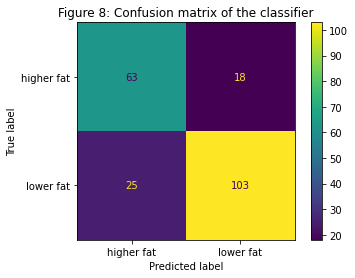

In [17]:
cm_plot = plot_confusion_matrix(random_search, X_test, y_test)
pl.title('Figure 8: Confusion matrix of the classifier')
pl.show()

The confusion matrix shows how many labels the model correctly identified. There are 63 true negatives and 103 true positives for a total of 166 correct predictions out of 209. 

Lastly, we can print a classification report for each type of score.

In [18]:
print(classification_report(y_test, random_search.predict(X_test)))

              precision    recall  f1-score   support

  higher fat       0.72      0.78      0.75        81
   lower fat       0.85      0.80      0.83       128

    accuracy                           0.79       209
   macro avg       0.78      0.79      0.79       209
weighted avg       0.80      0.79      0.80       209



**Table 7: Best Model Scores**

## Discussion

The question we were trying to answer was: **given a cheese with various qualities and measurements, how accurately can a machine learning model predict whether the cheese is classified as higher in fat or lower in fat?**

Our best performing `RandomForestClassifier` model produced a test score of 0.83 and weighted average accuracy of 0.80. Therefore, we can conclude that given a random cheese with specific qualities (including manufacturing type, moisture percent, organic class, cheese category, milk type and milk treatment), our model will correctly classify it as lower in fat with 80% accuracy. 

When comparing our best performing `RandomForestClassifier` model to the `DummyClassifier` baseline model, we can see that `RandomForestClassifier` produces much higher scores. The `DummyClassifier` validation F1 score was 0.65 and its validation accuracy score was 0.54. Thus, the `RandomForestClassifier` model performed significantly better. 

To improve our model, we could perform more cross validation folds (such as 10 folds) when tuning the hyperparameters. This would determine the best hyperparameters more accurately, and thus would result in higher scores. However, this would take a much longer time to produce. Additionally, it's possible that the feature columns that we dropped in the beginning could have contributed to a more accurate model, however, these variables were complex so they were dropped for simplicity. 

Further, it would be interesting to explore other models such as `KNeighborsClassifier`, `SVC` and `LogisticRegression` to see how their scores compare to our `RandomForestClassifier` model.

## References

Assignment 6: "Preprocessing Categorical Variables." 2023, https://canvas.ubc.ca/courses/114339/assignments/1548085.

Assignment 7: "Assessment and Measurements." 2023, https://canvas.ubc.ca/courses/114339/assignments/1548087.

Huppenkothen, Daniela. “Data Visualization: A Walkthrough in Python with Altair.” Data Visualization: A Walkthrough in Python with Altair – Data Visualization, 2022, [huppenkothen.org/data-visualization-tutorial/13-walkthrough-altair/index.html](huppenkothen.org/data-visualization-tutorial/13-walkthrough-altair/index.html).  

Module 7: "Assessment and Measurements." 2023, https://ml-learn.mds.ubc.ca/en/module7.

Satheesh, Vishnu. “Hyper Parameter Tuning (GRIDSEARCHCV vs RANDOMIZEDSEARCHCV).” Medium, 18 Apr. 2021, [medium.com/analytics-vidhya/hyper-parameter-tuning-gridsearchcv-vs-randomizedsearchcv-499862e3ca5](medium.com/analytics-vidhya/hyper-parameter-tuning-gridsearchcv-vs-randomizedsearchcv-499862e3ca5). 